In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy as scipy
from scipy.stats import pearsonr

pd.set_option('display.max_colwidth', None)

# Create a data frame from our student CSV Data. 
df = pd.read_csv('Student_Data_Stripped.csv')


# Create another data frame from our Tiger's Club Data. Select only the columns we are interested in. 
df_tc = pd.read_csv('Tigers_Club.csv')

# Create a third data frame from our behavior data. 
behavior_data = pd.read_csv('Student_Behavior.csv')

#RE-IMPORT THE DATA AFTER GROUPING IT AND MATCHING EMAILS
behavior_grouped = pd.read_csv('behavior_counts.csv')

#Import data for student enrollment dates
enroll_dates = pd.read_csv('Student Enrollment Dates.csv')


matplotlib.style.use('default')

# Data Colums Meaning (Abreviations)
- NF (Know a student by name and or face)
- KOS (Know what "Kind of Student" they are)
- KSP (Know something personal about this student)
- PC (Have a personal connection with this student)

- Ci (Reslife)
- X (Learning Coaches)
- Ch (Faculty)
- T (Change from first assessment to second assessment)

### All of these initial columns are the number of faculty, learning coaches and reslife that feel like they know this particular student at that level. 

# Cleaning and Organizing our Data

#### **Not going to include triangles at this point because it is a change and we would be double counting these people. 

First we are going to run some calculations on our data frame and create new colums from what we have to make our analysis a bit easier. 

- Need to create a student column to join on as many of the data frames I am using do not have an email address listed. 
- Total our levels of knowability as we are not looking at individual constituancy groups at this time. 
- Merging Tiger's Club and Community Service Data to our Main Data Frame
- Taking our behavior data, grouping by student, counting instances of behavior reports, and creating a new data frame with this grouped data. 

In [2]:
# Creating a Student Column 
df['Student'] = df['First Name'] + ' ' + df['Last Name']
# print(df.head())


# Totaling the amount of checks in each knowability group.
df['NF_Total'] = df.NF_Ci + df.NF_X + df.NF_Ch
df['KOS_Total'] = df.KOS_Ci + df.KOS_X + df.KOS_Ch
df['KSP_Total'] = df.KSP_Ci + df.KSP_X + df.KSP_Ch
df['PC_Total'] = df.PC_Ci + df.PC_X + df.PC_Ch

# Need the numbers of faculty, learning coaches, and res life that completed the survey. 
# These values below are within one or two of the actual amounts. 
num_reslife, num_learning_coaches, num_faculty = 5, 13, 22
num_people = num_reslife + num_learning_coaches + num_faculty


## Rec Cleaning

# Total all the different rec credits each student completed in a new colum
df_tc['Rec_Total'] = df_tc['Total Outdoor'] + df_tc['Total Cultural'] + df_tc['Total Service']

# Create a new data frame from a copy of the previous only showing the columns we are really interested in. 
df_tc_short = df_tc[['Email', 'Community Service', 'Rec_Total']].copy()

# Here is our joined data frame with the recreation data frame. 
df = df.join(df_tc_short.set_index("Email"), on='Email', how='inner')


## Behavior Cleaning
#### Did this in a different jupyter notebook. Saved it as a CSV and then manually entered the emails to be able to do an inner join.
###### Grouped Behavior data by counts of students in behavior log. 

# Merge with all student data. 
df_indexed = df.set_index('Email')
behavior_grouped.set_index("Email", inplace=True)
behavior_joined = pd.merge(df_indexed, behavior_grouped, left_index=True, right_index=True)


##Day vs. Boarding Cleaning
# Created a function to take a null value in dorm, replace it with zero, and create a new column for boarding vs. day students. 
df['Dorm'] = df['Dorm'].fillna("Day")
df['Boarding_Day'] = df['Dorm'].apply(lambda x: 'Day' if x == 'Day' else 'Boarding')



# Assessing Maximums and Minimums of Knowability


Will now find the maximum and minimum counts in each total of knowability column. 

In [3]:
max_NF = df.NF_Total.max()
max_KOS = df.KOS_Total.max()
max_KSP = df.KSP_Total.max()
max_PC = df.PC_Total.max()

min_NF = df.NF_Total.min()
min_KOS = df.KOS_Total.min()
min_KSP = df.KSP_Total.min()
min_PC = df.PC_Total.min()

maxes = [max_NF, max_KOS, max_KSP, max_PC]
mins = [min_NF, min_KOS, min_KSP, min_PC]

labels = ['Name / Face', 'Kind of Student', 'Something Personal', 'Personal Conneciton']
for i in range(0,4):
   print('The maximum count of adults who know a student by ' + labels[i] + ' is '  + str(round(maxes[i], 2))) 

print('\n')

for i in range(0,4):
    print('The minimum count of adults who know a student by ' + labels[i] + ' is '  + str(round(mins[i], 2)))



The maximum count of adults who know a student by Name / Face is 14
The maximum count of adults who know a student by Kind of Student is 9
The maximum count of adults who know a student by Something Personal is 14
The maximum count of adults who know a student by Personal Conneciton is 31


The minimum count of adults who know a student by Name / Face is 0
The minimum count of adults who know a student by Kind of Student is 0
The minimum count of adults who know a student by Something Personal is 0
The minimum count of adults who know a student by Personal Conneciton is 2


# Looking into Day vs. Boarding Students and Faculty Connections with Them. 
Below we will be comparing the ammount of personal connections and other levels of knowing students, comparing boarding studetns vs. day students. 



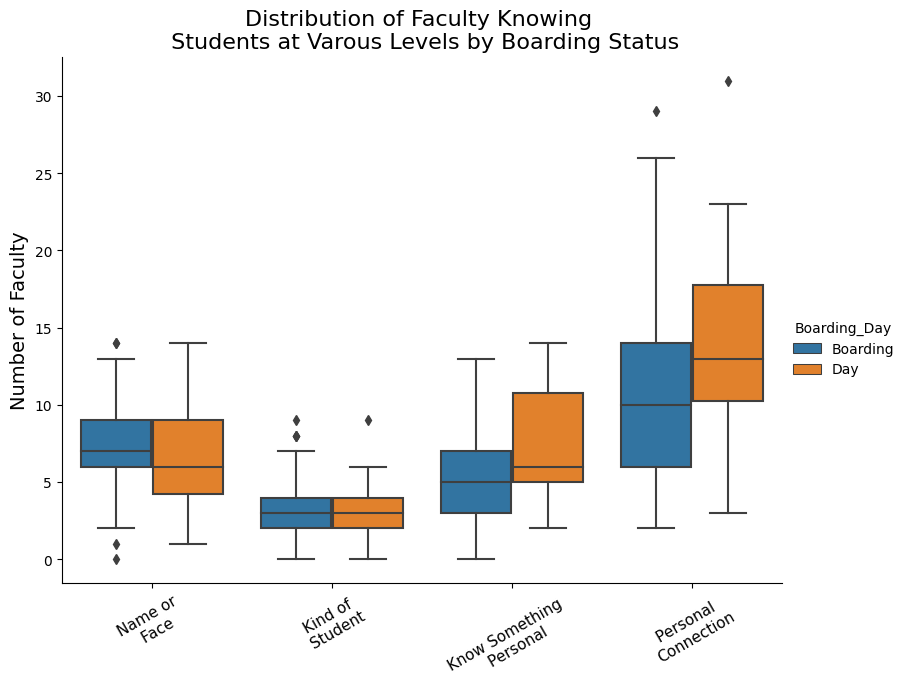


Below are the means of each level of knowability grouped by boarding vs. day students.

              NF_Total  KOS_Total  KSP_Total   PC_Total
Boarding_Day                                           
Boarding      7.219858   3.007092   4.971631  10.680851
Day           6.700000   3.166667   7.300000  13.866667


In [4]:
df_boarding_day = df[['Boarding_Day', 'NF_Total', 'KOS_Total', 'KSP_Total', 'PC_Total']].copy()


# Taking and unpivoting the data to better graph it.
df_boarding_day_melted = pd.melt(df_boarding_day, id_vars=['Boarding_Day'],
        var_name='Knowability', value_name='Counts')

# Plotting the data. 
sns.catplot(x="Knowability", y="Counts", hue="Boarding_Day", kind="box", data=df_boarding_day_melted, height=6, aspect=8/6)
plt.xticks([0, 1, 2, 3], ['Name or\n Face' , 'Kind of\n Student' , 'Know Something \n Personal' , 'Personal \nConnection'], rotation=30, fontsize = 11)
plt.ylabel("Number of Faculty", fontsize=14)
plt.xlabel("", fontsize=1)
plt.title("Distribution of Faculty Knowing \n Students at Varous Levels by Boarding Status", fontsize = 16)
plt.show()

# Here we are just quickly showing the mean values of each level of knowability in each gender. 
print("\nBelow are the means of each level of knowability grouped by boarding vs. day students.\n")
print(df_boarding_day.groupby("Boarding_Day").mean())

# Box Plot Showing the Spread of Student Knowability in Different Categories


We are looking at all of the students and displaying the spread of knowability in each of the categories. These boxplots show the interquartile range and the spread of the data for each knowability category. 

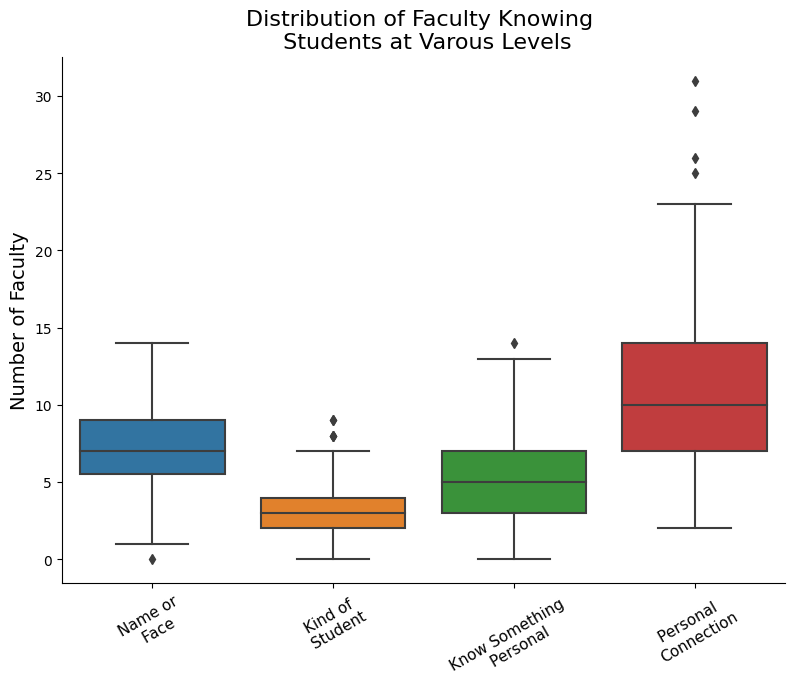

In [5]:
# Pulling just the columns I am interested in looking at for the levels of knowability vs. gender. 
df_totals = df[['First Name', 'NF_Total', 'KOS_Total', 'KSP_Total', 'PC_Total']].copy()

# Taking and unpivoting the data to better graph it.
df_totals = pd.melt(df_totals, id_vars=['First Name'],
        var_name='Knowability', value_name='Counts')

# Plotting the data. 
sns.catplot(x="Knowability", y="Counts", kind="box", data=df_totals, height=6, aspect=8/6)
plt.xticks([0, 1, 2, 3], ['Name or\n Face' , 'Kind of\n Student' , 'Know Something \n Personal' , 'Personal \nConnection'], rotation=30, fontsize = 11)
plt.ylabel("Number of Faculty", fontsize=14)
plt.xlabel("", fontsize=1)
plt.title("Distribution of Faculty Knowing \n Students at Varous Levels", fontsize = 16)
plt.show()

# Pulling list of students with lowest personal connections. 
lowest_PCs = df[df['PC_Total'] < 5]
lowest_PCs = lowest_PCs[['First Name', 'Last Name', "Grade", 'PC_Total']]

# print(lowest_PCs)

# Looking at Student Knowability Based on Recreation Credits Earned

We are interested in seeing if there is any correlation between the number of rec credits earned and the number of faculty that have a personal connection each student. Below is a scatter plot with the number of recreation credits earned by each student plotted against the number of personal connections this student has with faculty and staff members. 

- NOTE: The only recreation data available is trips that earn recreation credits. This is a small number of the total amount of recreation trips, but it is the data available. 
- NOTE: It would be interesting to start to collect recreation data for all recreation trips. Is there a way to streamline the recreation attendance that would allow for better data collection and entry. 


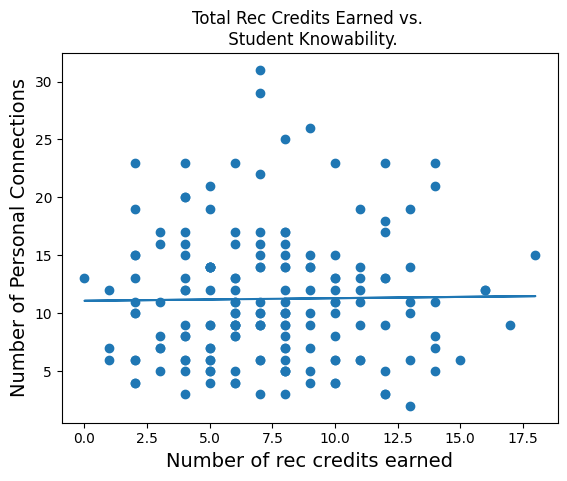

0.014518789117917085


In [6]:
plt.scatter(df['Rec_Total'], df['PC_Total'])


m, b = np.polyfit(df['Rec_Total'], df['PC_Total'], 1)
plt.plot(df['Rec_Total'], m*df['Rec_Total'] + b, )
plt.title('Total Rec Credits Earned vs. \n Student Knowability.')
plt.xlabel('Number of rec credits earned', fontsize=14)
plt.ylabel('Number of Personal Connections', fontsize=14)
plt.show()


corr_rec_knowability, p = pearsonr(df['Rec_Total'], df['PC_Total'])
print(corr_rec_knowability)


# Looking at Student Knowability Based on Total Community Service Hours Completed

We are interested in seeing if there is any correlation between the number of community service hours earned and the number of faculty that have a personal connection each student. Below is a scatter plot with the number of community service hourse completed by each student plotted against the number of personal connections this student has with faculty and staff members. 

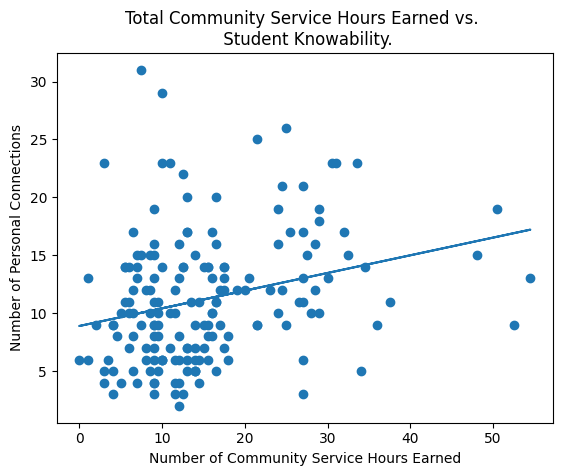

0.2707589121393432


In [7]:
plt.scatter(df['Community Service'], df['PC_Total'])

m, b = np.polyfit(df['Community Service'], df['PC_Total'], 1)
plt.plot(df['Community Service'], m*df['Community Service'] + b, )

plt.title('Total Community Service Hours Earned vs. \n Student Knowability.')
plt.xlabel('Number of Community Service Hours Earned')
plt.ylabel('Number of Personal Connections')
plt.show()

corr_service_knowability, p = pearsonr(df['Community Service'], df['PC_Total'])
print(corr_service_knowability)



# Looking at Student Knowability Based on Counts of Student on Behavior Log

We are interested in seeing if there is any correlation between the number of times a student is on the behavior log and number of personal connections.

NOTE: Studetns were only included on this with one or more counts of behavior instances. 

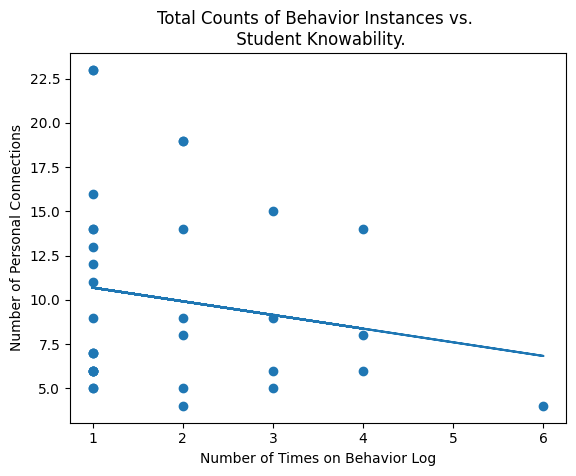

-0.17678168939588323


In [8]:
plt.scatter(behavior_joined['Counts'], behavior_joined['PC_Total'])

m, b = np.polyfit(behavior_joined['Counts'], behavior_joined['PC_Total'], 1)
plt.plot(behavior_joined['Counts'], m*behavior_joined['Counts'] + b, )

plt.title('Total Counts of Behavior Instances vs. \n Student Knowability.')
plt.xlabel('Number of Times on Behavior Log')
plt.ylabel('Number of Personal Connections')
plt.show()

corr_behavior_knowability, p = pearsonr(behavior_joined['Counts'], behavior_joined['PC_Total'])
print(corr_behavior_knowability)


# Male vs. Female Boxplots



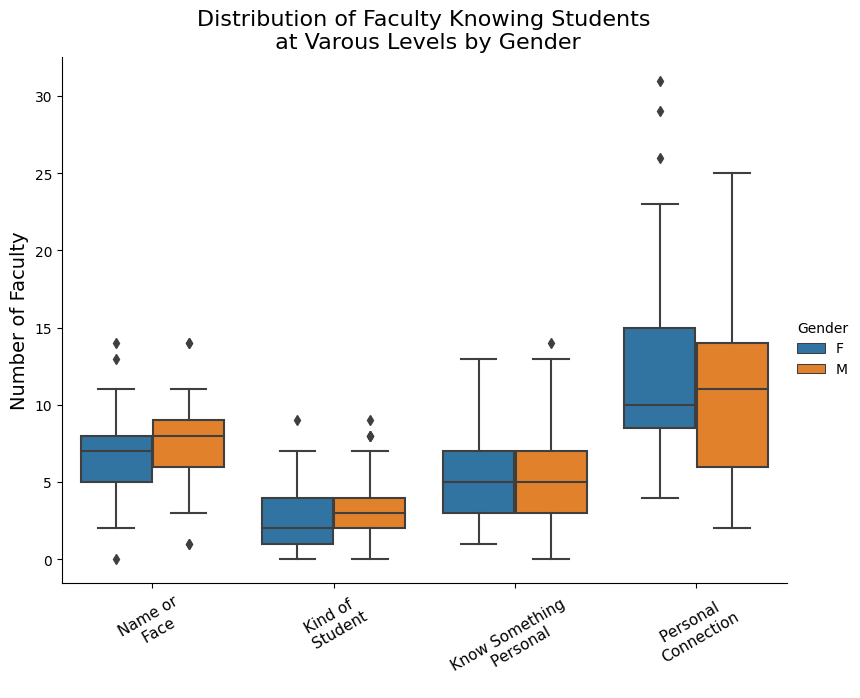


Below are the means of each level of knowability grouped by gender.

        NF_Total  KOS_Total  KSP_Total   PC_Total
Gender                                           
F       6.508475   2.661017   5.355932  12.050847
M       7.455357   3.232143   5.392857  10.812500


In [9]:
# Pulling just the columns I am interested in looking at for the levels of knowability vs. gender. 
df_male_female = df[['Gender', 'NF_Total', 'KOS_Total', 'KSP_Total', 'PC_Total']].copy()

# Taking and unpivoting the data to better graph it.
df_male_female_melted = pd.melt(df_male_female, id_vars=['Gender'],
        var_name='Knowability', value_name='Counts')

# Plotting the data. 
sns.catplot(x="Knowability", y="Counts", hue="Gender", kind="box", data=df_male_female_melted, height=6, aspect=8/6)
plt.xticks([0, 1, 2, 3], ['Name or\n Face' , 'Kind of\n Student' , 'Know Something \n Personal' , 'Personal \nConnection'], rotation=30, fontsize = 11)
plt.ylabel("Number of Faculty", fontsize=14)
plt.xlabel("", fontsize=1)
plt.title("Distribution of Faculty Knowing Students\n at Varous Levels by Gender", fontsize = 16)
plt.show()

# Here we are just quickly showing the mean values of each level of knowability in each gender. 
print("\nBelow are the means of each level of knowability grouped by gender.\n")
print(df_male_female.groupby("Gender").mean())

# Histograms showing counts of students. 
I am going to make some histograms showing the value counts of number of faculty and staff knowing our students at various levels. 

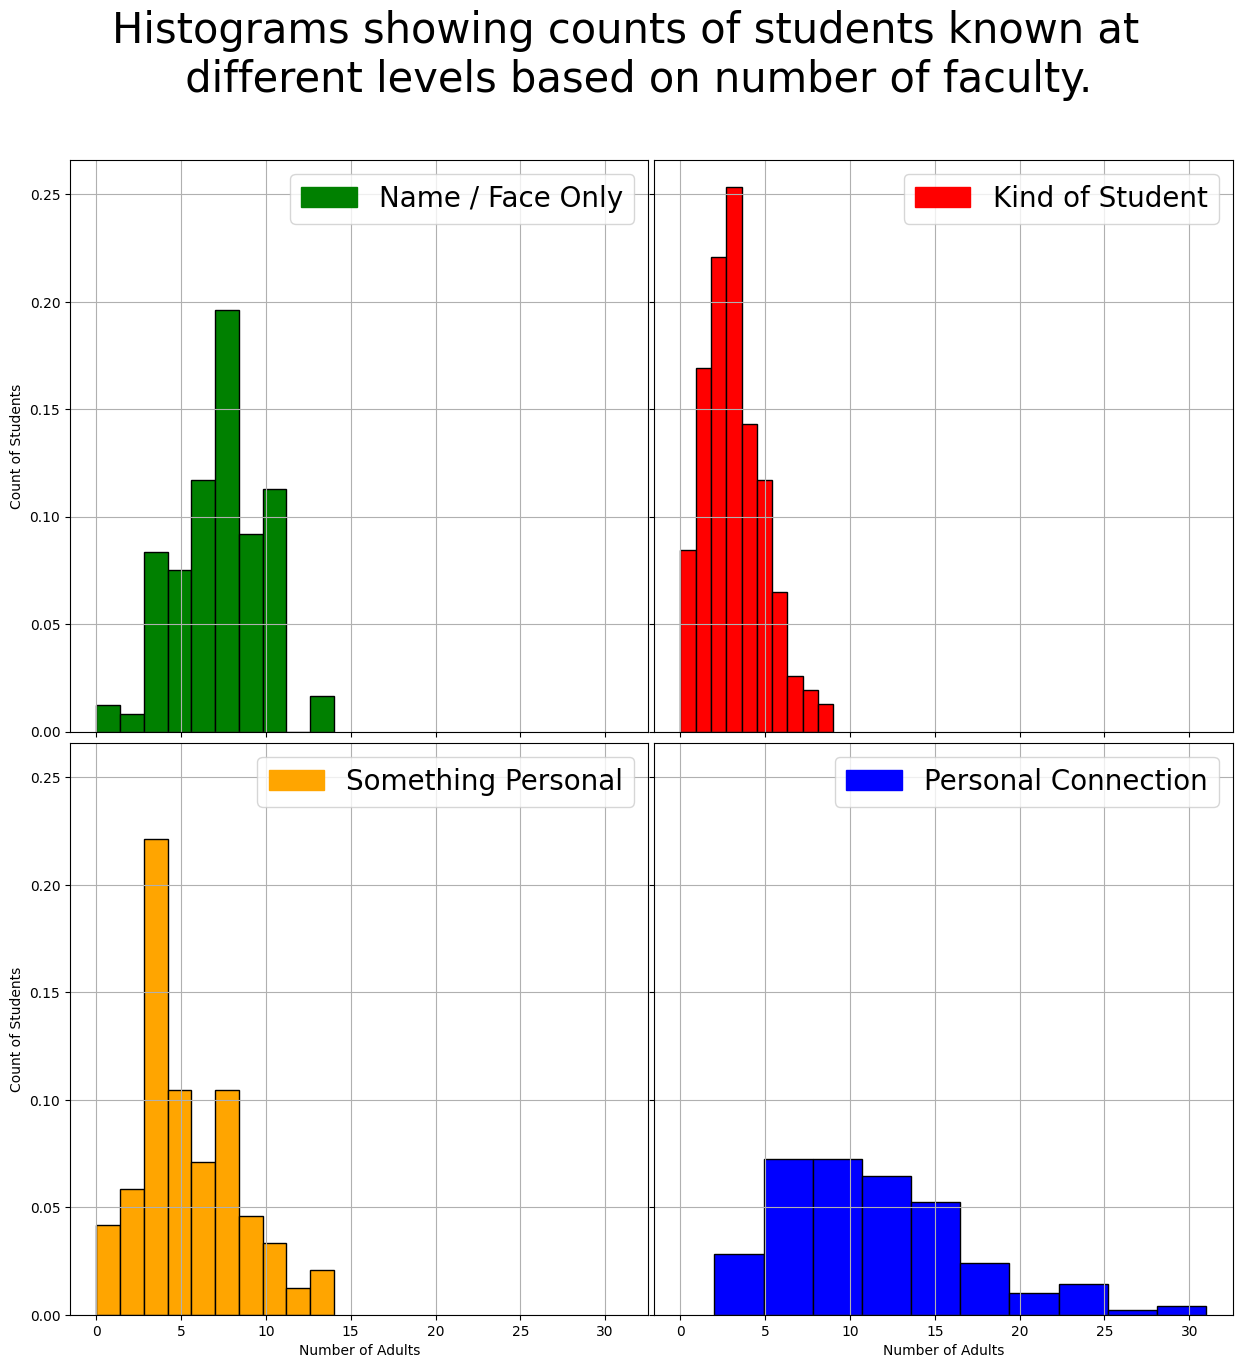

In [10]:
# Possible way to group the histograms in a series of four. 
# Getting a list of values to be able to pull into a histogram. 
NF_Total_Values = df['NF_Total'].values
KOS_Total_Values = df['KOS_Total'].values
KSP_Total_Values = df['KSP_Total'].values
PC_Total_Values = df['PC_Total'].values
# Showing data now. Just need to find out how to add labels to each of these subplots and go from there. 

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharey=True, sharex=True)


axs[0, 0].hist(NF_Total_Values, color='green', edgecolor = "black", density=True)
axs[0,0].set(ylabel='Count of Students')
axs[0, 0].grid()
name_face_patch = mpatches.Patch(color='green', label='Name / Face Only')
axs[0, 0].legend(handles=[name_face_patch], fontsize = 20)


axs[0, 1].hist(KOS_Total_Values, color='red', edgecolor = "black", density=True)
axs[0, 1].grid()
KOS_patch = mpatches.Patch(color='red', label='Kind of Student')
axs[0, 1].legend(handles=[KOS_patch], fontsize = 20)


axs[1, 0].hist(KSP_Total_Values, color='orange', edgecolor = "black", density=True)
axs[1,0].set(xlabel='Number of Adults', ylabel='Count of Students')
axs[1, 0].grid()
KSP_patch = mpatches.Patch(color='orange', label='Something Personal')
axs[1, 0].legend(handles=[KSP_patch], fontsize = 20)


axs[1, 1].hist(PC_Total_Values, color='blue', edgecolor = "black", density=True)
axs[1,1].set(xlabel='Number of Adults')
axs[1, 1].grid()
PC_patch = mpatches.Patch(color='blue', label='Personal Connection')
axs[1, 1].legend(handles=[PC_patch], fontsize = 20)

fig.suptitle("Histograms showing counts of students known at \n different levels based on number of faculty.", fontsize = 30)
# plt.rc('axes', labelsize=24)
# plt.rc('xtick', labelsize=18)
# plt.rc('ytick', labelsize=18)
fig.subplots_adjust(hspace=0.02, wspace=0.01)



plt.show()

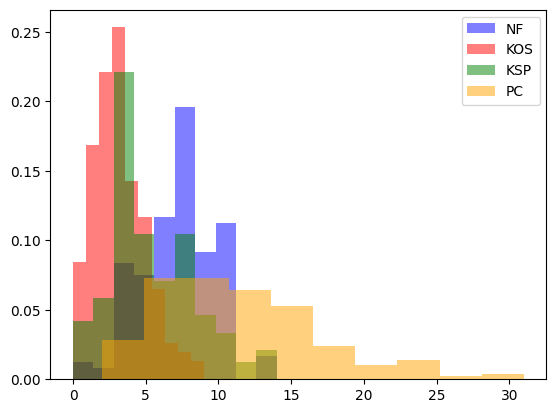

In [11]:
plt.hist(NF_Total_Values, color='blue', label='NF', density=True, alpha= 0.5)
plt.hist(KOS_Total_Values, color='red', label='KOS', density=True, alpha= 0.5)
plt.hist(KSP_Total_Values, color='green', label='KSP', density=True, alpha= 0.5)
plt.hist(PC_Total_Values, color='orange', label='PC', density=True, alpha= 0.5)
plt.legend()
plt.show()


# This is looking at the percentage of checks in each category. Another interesting statistic to look at. Potentially do this with a box plot to show the spread of the percentages. Could give us different insights. 

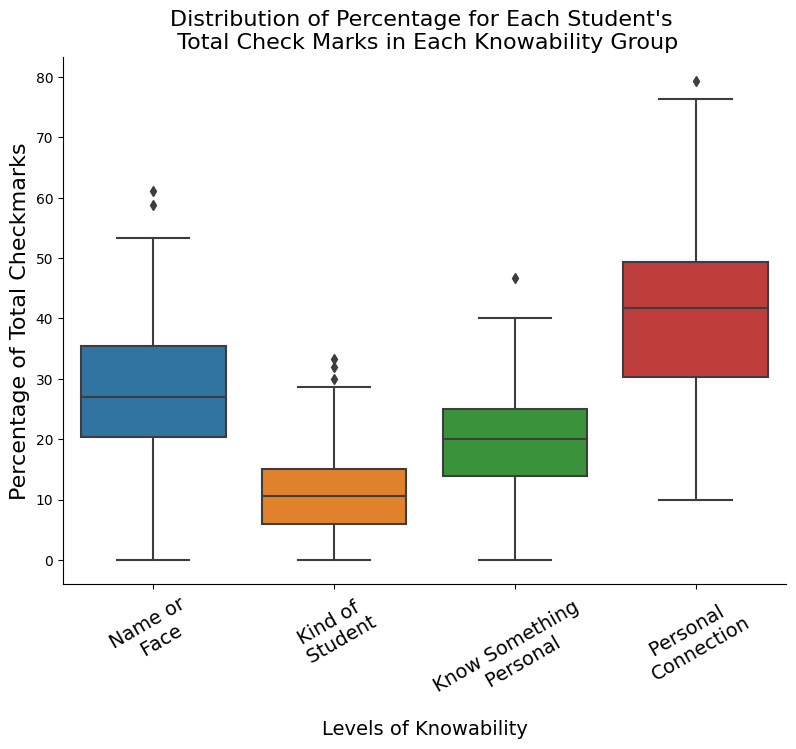

6
    First Name Last Name  Grade             Dorm  NF_Total  KOS_Total  \
2       Andrik     Essey      8              Day        10          2   
93     An Quoc        Le     11  Centennial Dorm        11          2   
117      Gavin    Turner     11  Centennial Dorm         8          0   

     KSP_Total  PC_Total  Total_Marks  NF_Percentage  KOS_Percentage  \
2            2         3           17      58.823529       11.764706   
93           1         4           18      61.111111       11.111111   
117          3         4           15      53.333333        0.000000   

     KSP_Percentage  PC_Percentage  
2         11.764706      17.647059  
93         5.555556      22.222222  
117       20.000000      26.666667  


In [12]:
# Make a new data frame pulling just the totals. 
# Using .copy() made it so there is not a chained indexing error message. This seems to be a cleaner way to do thigns. 
df_new = df[['First Name', 'Last Name', 'Grade', 'Dorm', 'NF_Total', 'KOS_Total', 'KSP_Total', 'PC_Total']].copy()
# print(df_new.sample(20))


df_new['Total_Marks'] = df['NF_Total'] + df['KOS_Total'] + df['KSP_Total'] + df['PC_Total']

df_new['NF_Percentage'] = df_new['NF_Total']/df_new['Total_Marks']*100
df_new['KOS_Percentage'] = df_new['KOS_Total']/df_new['Total_Marks']*100
df_new['KSP_Percentage'] = df_new['KSP_Total']/df_new['Total_Marks']*100
df_new['PC_Percentage'] = df_new['PC_Total']/df_new['Total_Marks']*100

df_new_melted = pd.melt(df_new[['First Name', 'NF_Percentage', 'KOS_Percentage', 'KSP_Percentage', 'PC_Percentage']], id_vars=['First Name'],
        var_name='Knowability', value_name='Percentage')
sns.catplot(x="Knowability", y="Percentage", kind="box", data=df_new_melted, height=6, aspect=8/6)
plt.xticks([0, 1, 2, 3], ['Name or\n Face' , 'Kind of\n Student' , 'Know Something \n Personal' , 'Personal \nConnection'], rotation=30, fontsize = 14)
plt.ylabel("Percentage of Total Checkmarks", fontsize=16)
plt.xlabel("Levels of Knowability", fontsize=14)
plt.title("Distribution of Percentage for Each Student's \n Total Check Marks in Each Knowability Group", fontsize = 16)
plt.show()


#Gets us the count of the query below
print(df_new[(df_new['PC_Percentage'] < 20) & (df_new['PC_Total'] < 5)].shape[0])

print(df_new[(df_new['PC_Percentage'] < 30) & (df_new['NF_Percentage'] > 50)])



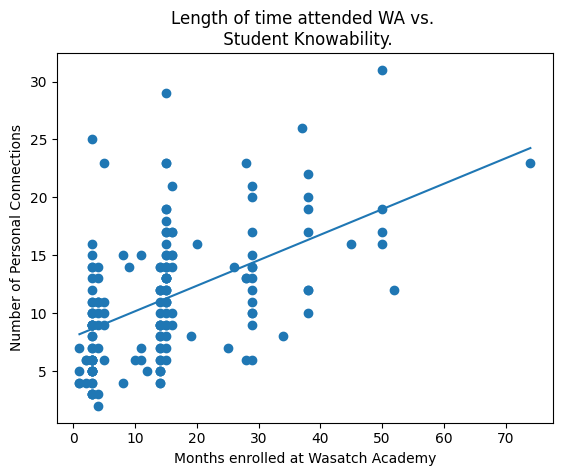

0.5081692051760371


In [13]:

##Length of time cleaning
enroll_dates['Date'] = '12/1/21'

enroll_dates['Date'] = pd.to_datetime(enroll_dates['Date'])
enroll_dates['Enroll Date'] = pd.to_datetime(enroll_dates['Enroll Date'])

enroll_dates['Months Attended'] = ((enroll_dates['Date'] - enroll_dates['Enroll Date'])/np.timedelta64(1, 'M'))
enroll_dates['Months Attended'] = enroll_dates['Months Attended'].astype(int)

time_at_wa = enroll_dates[['Student_Email_Address', 'Months Attended']]

df_time = df[['Email', 'PC_Total']].copy()

time_at_wa = time_at_wa.set_index('Student_Email_Address')
df_time.set_index("Email", inplace=True)
time_at_wa_joined = pd.merge(time_at_wa, df_time, left_index=True, right_index=True)



plt.scatter(time_at_wa_joined['Months Attended'], time_at_wa_joined['PC_Total'])

m, b = np.polyfit(time_at_wa_joined['Months Attended'], time_at_wa_joined['PC_Total'], 1)
plt.plot(time_at_wa_joined['Months Attended'], m*time_at_wa_joined['Months Attended'] + b, )

plt.title('Length of time attended WA vs. \n Student Knowability.')
plt.xlabel('Months enrolled at Wasatch Academy')
plt.ylabel('Number of Personal Connections')
plt.show()


# Generally, a correlation larger than about .3 indicates a linear association. A correlation greater than about .6 suggestions a strong linear association.
corr_length_knowability, p = pearsonr(time_at_wa_joined['Months Attended'], time_at_wa_joined['PC_Total'])
print(corr_length_knowability) #output: 0.507